In [1]:
#Import Statements
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import sqlite3
from zipfile import ZipFile

import string
import regex as re

%matplotlib inline

In [26]:
color_palette = ["#86BC25"] #Set Color of PLots to Deloitte Green
sns.set_palette(palette=color_palette)

# Import Data 

In [11]:
the_numbers = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
the_numbers.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [ ]:
#Run only first time to unzip the file

#Confirm with Instructors if we need to have this run
file_name = "./zippedData/im.db.zip"
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    #zip.printdir()
    zip.extractall()

In [6]:
conn = sqlite3.connect('./im.db')

# Data Cleaning and EDA

In [13]:
def make_int(string):
    return int(string.replace("$","").replace(",",""))

In [14]:
the_numbers['production_budget'] = the_numbers['production_budget'].apply(lambda x: make_int(x))
the_numbers['domestic_gross'] = the_numbers['domestic_gross'].apply(lambda x: make_int(x))
the_numbers['worldwide_gross'] = the_numbers['worldwide_gross'].apply(lambda x: make_int(x))

#Creates a date time from release date
the_numbers['release_date']=(
    pd.to_datetime(the_numbers['release_date'], format='%b %d, %Y'))

#Creates a new title column
the_numbers['title']= (
    the_numbers['movie'].map(
        lambda x :''.join(filter(str.isalnum, x)).lower()))

the_numbers['days'] = the_numbers["release_date"].dt.day_name()
the_numbers['months'] = the_numbers["release_date"].dt.month_name()
the_numbers['year'] = the_numbers["release_date"].dt.year

In [16]:
the_numbers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   int64         
 4   domestic_gross     5782 non-null   int64         
 5   worldwide_gross    5782 non-null   int64         
 6   title              5782 non-null   object        
 7   days               5782 non-null   object        
 8   months             5782 non-null   object        
 9   year               5782 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 451.8+ KB


# Production Budget

In [22]:
def z_score(value, mean, std):
    return (value - mean) / std

In [23]:
the_numbers_mean = the_numbers['worldwide_gross'].mean()
the_numbers_med = the_numbers['worldwide_gross'].median()
the_numbers_std = the_numbers['worldwide_gross'].std()

print(the_numbers_mean)
print(the_numbers_med)

the_numbers['z_score'] = the_numbers['worldwide_gross'].apply(lambda x: z_score(x, the_numbers_mean, the_numbers_std))

91487460.90643376
27984448.5


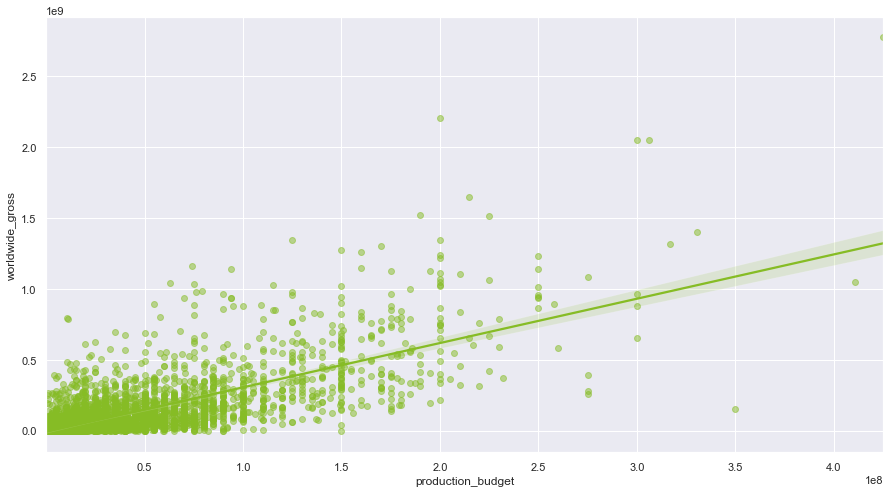

In [27]:
sns.regplot(data=the_numbers, x='production_budget', y='worldwide_gross', 
            scatter_kws={'alpha':0.5})
sns.set(rc={'figure.figsize':(15,8)})

In [30]:
gross_outliers = the_numbers[the_numbers['z_score'] > 3]
outliers_movies_lst = list(gross_outliers['movie'].values)
outliers_movies_lst[:5]

['Avatar',
 'Pirates of the Caribbean: On Stranger Tides',
 'Avengers: Age of Ultron',
 'Star Wars Ep. VIII: The Last Jedi',
 'Star Wars Ep. VII: The Force Awakens']

In [31]:
imdb_people = pd.read_sql(f"""
SELECT pr.person_id, primary_name, death_year, category, primary_title,
       original_title
FROM persons p
LEFT JOIN principals pr ON pr.person_id = p.person_id
LEFT JOIN movie_basics mb ON pr.movie_id = mb.movie_id
""", conn)

In [37]:
#Make Sure Personnel is Alive
imdb_alive = imdb_people[imdb_people['death_year'].isnull() == True] 

#Check if Person is in List of Outliers
imdb_outliers = imdb_alive[imdb_alive['primary_title'].isin(outliers_movies_lst)]
display(imdb_outliers)

#Group Outliers Togeter to Get Counts
grouped = imdb_outliers.groupby(['category','primary_name']).size().reset_index(name='counts')
grouped.head()

,person_id,primary_name,death_year,category,primary_title,original_title
480,nm0125336,Jez Butterworth,NaN,writer,Spectre,Spectre
2286,nm0671567,Michael Peña,NaN,actor,Ant-Man and the Wasp,Ant-Man and the Wasp
2797,nm0834902,Robert Stromberg,NaN,director,Maleficent,Maleficent
2799,nm0837112,Richard Suckle,NaN,producer,Suicide Squad,Suicide Squad
3273,nm1014201,Rhett Reese,NaN,writer,Deadpool,Deadpool
...,...,...,...,...,...,...
1005549,nm9989238,Suneet Gautam,NaN,composer,Titanic,Titanic
1009487,nm9989231,Mahesh Vashisht,NaN,composer,Titanic,Titanic
1013926,nm9039216,Neil Boultby,NaN,actor,Coco,Coco
1029087,nm9061881,Natalia Kaverznikova,NaN,actress,Coco,Coco


,category,primary_name,counts
0,actor,Aarif Rahman,1
1,actor,Adil Hussain,1
2,actor,Alan Mathis,1
3,actor,Alan Tudyk,1
4,actor,Albert Brooks,1


In [45]:
grouped['counts'].mean() + (3 * grouped['counts'].std())

3.5381775991830686

In [46]:
grouped3 = grouped[grouped['counts'] > 4]

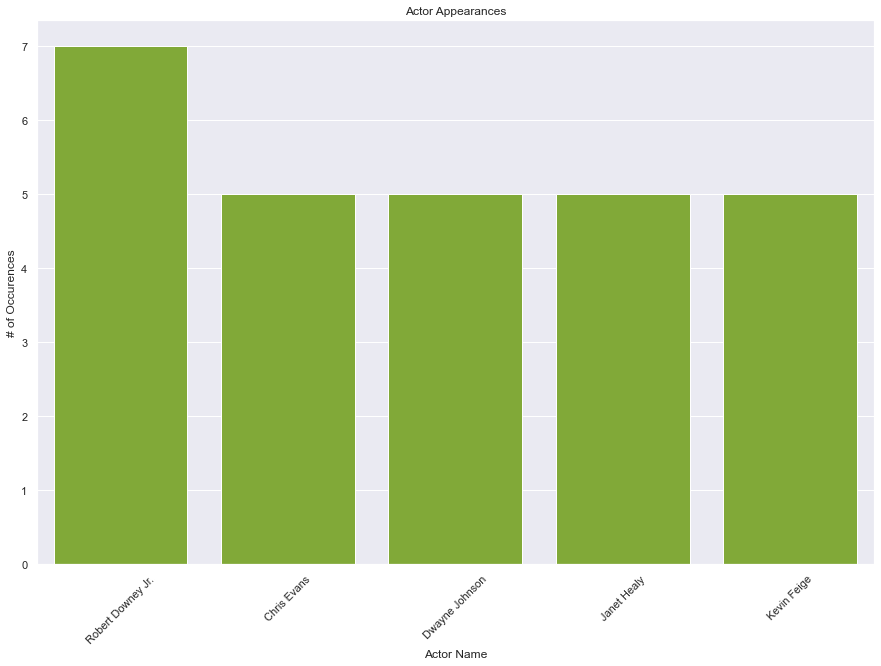

In [47]:
ax = sns.barplot(x="primary_name", y="counts", data=grouped3, color="#86BC25", order=grouped3.sort_values('counts', ascending=False).primary_name)
sns.set(rc={'figure.figsize':(15,10)})
ax.set_title("Actor Appearances")
ax.set_xlabel("Actor Name")
ax.set_ylabel("# of Occurences")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

plt.show()

# Genre